In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path

In [2]:
eu_df = pd.read_csv('EUForestspecies.csv')

In [3]:
treesat_df = gpd.read_file('../treesatai/bb_60m.geojson')

In [4]:
multi_treesat_df = pd.read_csv('../treesatai/bb_60m_multilabel.csv')

In [5]:
treesat_df = treesat_df.to_crs('EPSG:3035')

In [6]:
treesat_points = treesat_df.geometry.centroid.get_coordinates()
treesat_points = treesat_points.div(1000).astype(int).mul(1000) + 500

In [7]:
treesat_points = treesat_points.rename(mapper={'x': 'X', 'y': 'Y'}, axis=1)

In [8]:
treesat_points_grouped = treesat_points.groupby(['X', 'Y']).head(1)
treesat_points_grouped.shape

(5939, 2)

In [9]:
pd.merge(treesat_points_grouped, eu_df.groupby(['X', 'Y']).head(1), on=['X', 'Y'], how='inner').shape

(376, 10)

Due to the small number of regions of interest in common, TreeSatAI can be used as a test dataset.

In [10]:
treesat_df['BT_BOT'].unique()

array(['Fagus sylvatica', 'Picea abies', 'Acer pseudoplatanus',
       'Prunus spec.', 'Fraxinus excelsior', 'Pinus nigra',
       'Quercus petraea', 'Tilia spec.', 'Alnus spec.', 'Betula spec.',
       'Quercus rubra', 'Pinus sylvestris', 'Pseudotsuga menziesii',
       'Quercus robur', 'Larix decidua', 'Populus spec.', 'Abies alba',
       'Larix kaempferi', 'Pinus strobus', 'Cleared'], dtype=object)

In [11]:
for s in np.unique(treesat_df['BT_BOT']):
    occurrences = eu_df['SPECIES NAME'].str.contains(s).sum()
    print(s, occurrences)
    if occurrences == 0:
        print(eu_df['SPECIES NAME'][eu_df['SPECIES NAME'].str.contains(s.split(' ')[0])].unique())
    print()

Abies alba 9383

Acer pseudoplatanus 12412

Alnus spec. 0
['Alnus alnobetula' 'Alnus glutinosa' 'Alnus incana' 'Alnus cordata']

Betula spec. 0
['Betula pendula' 'Betula pubescens' 'Betula nana' 'Betula humilis']

Cleared 0
[]

Fagus sylvatica 35862

Fraxinus excelsior 17891

Larix decidua 8204

Larix kaempferi 3323

Picea abies 70310

Pinus nigra 10652

Pinus strobus 355

Pinus sylvestris 75720

Populus spec. 0
['Populus alba' 'Populus canescens' 'Populus nigra' 'Populus tremula'
 'Populus balsamifera']

Prunus spec. 0
['Prunus avium' 'Prunus padus' 'Prunus spinosa' 'Prunus serotina'
 'Prunus domestica' 'Prunus cerasifera' 'Prunus brigantina'
 'Prunus cerasus' 'Prunus dulcis' 'Prunus mahaleb' 'Prunus virginiana'
 'Prunus persica' 'Prunus armeniaca' 'Prunus lusitanica']

Pseudotsuga menziesii 5255

Quercus petraea 17117

Quercus robur 31079

Quercus rubra 1735

Tilia spec. 0
['Tilia cordata' 'Tilia platyphyllos' 'Tilia tomentosa']



In [12]:
cols = [
    'Pseudotsuga',
    'Abies', 'Larix', 'Acer', 'Picea', 'Betula', 'Cleared', 'Fagus',
    'Quercus', 'Fraxinus', 'Pinus', 'Alnus', 'Populus', 'Prunus', 'Tilia'
]
multi_treesat_df[cols].columns.shape

(15,)

In [13]:
grouped_treesat = pd.concat([treesat_points, multi_treesat_df[cols]], axis=1)
grouped_treesat = grouped_treesat.groupby(['X', 'Y'], as_index=False).sum()
grouped_treesat.head()

X        Y  Pseudotsuga  Abies     Larix  Acer   Picea    Betula  \
0  4109500  3275500      0.08803    0.0  1.208397   0.0  0.7208  0.000000   
1  4110500  3275500      0.00000    0.0  0.000000   0.0  0.0000  0.000000   
2  4123500  3298500      0.00000    0.0  0.000000   0.0  0.0000  1.519621   
3  4123500  3299500      0.00000    0.0  0.000000   0.0  0.0000  4.000000   
4  4127500  3262500      0.00000    0.0  0.070869   0.0  0.0000  0.000000   

   Cleared  Fagus    Quercus  Fraxinus     Pinus  Alnus  Populus  Prunus  \
0  0.00000    0.0  13.918833       0.0  0.063940    0.0      0.0     0.0   
1  1.49334    0.0   6.317590       0.0  0.189070    0.0      0.0     0.0   
2  0.00000    0.0   0.480379       0.0  0.000000    0.0      0.0     0.0   
3  0.00000    0.0   0.000000       0.0  0.000000    0.0      0.0     0.0   
4  0.00000    0.0   0.017220       0.0  3.911911    0.0      0.0     0.0   

   Tilia  
0    0.0  
1    0.0  
2    0.0  
3    0.0  
4    0.0

In [14]:
grouped_treesat_gdf = gpd.GeoDataFrame(
    grouped_treesat.drop(labels=['X', 'Y'], axis=1), 
    geometry=gpd.points_from_xy(x=grouped_treesat.X, y=grouped_treesat.Y, crs='EPSG:3035')
)
grouped_treesat_gdf.geometry = grouped_treesat_gdf.buffer(500, cap_style=3).to_crs(epsg=4326)
grouped_treesat_gdf.shape

(5939, 16)

In [ ]:
%%capture
%run euforest.ipynb

In [16]:
treesat_bbox = ee.Geometry.BBox(*(grouped_treesat_gdf.geometry.total_bounds + 0.01))

In [17]:
labels = grouped_treesat_gdf.drop('geometry', axis=1)
labels = labels.apply(
    lambda row:', '.join([col for col in labels.columns[1:] if row[col]]) , axis=1)

In [18]:
# visualise(gpd.GeoDataFrame(labels, geometry=grouped_treesat_gdf.geometry), treesat_bbox)

Download TreeSatAI regions with medians over summer months between start and end date.

In [19]:
parent_dir = Path.home().joinpath('sentinel_data')
raw_data_path = parent_dir.joinpath('raw_treesat')
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2020, 1, 1)
run_jobs(raw_data_path, grouped_treesat_gdf, treesat_bbox, start_date, end_date)

In [20]:
grouped_treesat_gdf.head(2)

Pseudotsuga  Abies     Larix  Acer   Picea  Betula  Cleared  Fagus  \
0      0.08803    0.0  1.208397   0.0  0.7208     0.0  0.00000    0.0   
1      0.00000    0.0  0.000000   0.0  0.0000     0.0  1.49334    0.0   

     Quercus  Fraxinus    Pinus  Alnus  Populus  Prunus  Tilia  \
0  13.918833       0.0  0.06394    0.0      0.0     0.0    0.0   
1   6.317590       0.0  0.18907    0.0      0.0     0.0    0.0   

                                            geometry  
0  POLYGON ((6.88822 52.55258, 6.88885 52.54361, ...  
1  POLYGON ((6.90295 52.55297, 6.90358 52.54399, ...

In [21]:
%%capture
%run explore_sentinel_data.ipynb

In [22]:
raw_treesat_dir = parent_dir.joinpath('raw_treesat')
treesat_shards_dir = parent_dir.joinpath('treesat_shards')

sort_key = lambda x: int(x.stem.split('_')[-1])
treesat_features_filepaths = sorted(list(raw_treesat_dir.glob('features_*.npy')), key=sort_key)
treesat_labels_filepaths = sorted(list(raw_treesat_dir.glob('labels_*.csv')), key=sort_key)

treesat_parts = [int(f.stem.split('_')[-1]) for f in treesat_features_filepaths]
map_inputs = [(i, l, f, treesat_shards_dir) for i, l, f in zip(
    treesat_parts, treesat_labels_filepaths, treesat_features_filepaths)]

n_processes = 8
with Pool(processes=n_processes) as p:
    p.starmap(create_shards, tqdm(map_inputs, total=len(treesat_parts)), chunksize=1)

  0%|          | 0/6 [00:00<?, ?it/s]

In [23]:
%%capture
%run conv_median.ipynb

2024-06-17 14:22:46.900869: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 14:22:46.984399: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-17 14:22:47.292526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-17 14:22:48.688775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [24]:
y_preds_path = model_path.with_suffix('.treesat_preds.npy')
y_truths_path = model_path.with_suffix('.treesat_truths.npy')
if y_preds_path.is_file():
    y_pred = np.load(y_preds_path)
    y_true = np.load(y_truths_path)
else:
    preds = []
    truths = []
    for part in tqdm(treesat_parts):
        feature_chunks = []
        for ID in range(part*1000, (part+1)*1000):
            feature = treesat_shards_dir.joinpath(f'feature_{ID}.npy')
            label = treesat_shards_dir.joinpath(f'label_{ID}.npy')
            
            if not feature.is_file():
                break
                
            feature_chunks.append(np.load(feature))
            truths.append(np.load(label))
        
        pred = model.predict(np.stack(feature_chunks), verbose=0)
        preds.append(pred)
    y_pred = np.vstack(preds)
    y_true = np.vstack(truths)
    np.save(y_truths_path, y_true)
    np.save(y_preds_path, y_pred)

  0%|          | 0/6 [00:00<?, ?it/s]

2024-06-17 14:22:57.577057: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 520000000 exceeds 10% of free system memory.
2024-06-17 14:23:02.757543: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 520000000 exceeds 10% of free system memory.
2024-06-17 14:23:07.461732: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 520000000 exceeds 10% of free system memory.
2024-06-17 14:23:12.479752: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 520000000 exceeds 10% of free system memory.
2024-06-17 14:23:17.615950: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 520000000 exceeds 10% of free system memory.


In [37]:
y_pred.shape, y_true.shape

((5939, 242), (5939, 15))

In [27]:
treesat_classes = pd.read_csv(raw_treesat_dir.joinpath('labels_0.csv')).columns
treesat_classes.shape

(15,)

In [28]:
eu_classes = pd.read_csv(parent_dir.joinpath('raw_data').joinpath('labels_0.csv')).columns
eu_classes.shape

(242,)

In [29]:
y_pred_df = pd.DataFrame(y_pred, columns=eu_classes) > 0.5
y_pred_df.head()

Abies alba  Abies cephalonica  Abies grandis  Abies nordmanniana  \
0       False              False          False               False   
1       False              False          False               False   
2       False              False          False               False   
3       False              False          False               False   
4       False              False          False               False   

   Abies pinsapo  Abies procera  Acacia dealbata  Acacia melanoxylon  \
0          False          False            False               False   
1          False          False            False               False   
2          False          False            False               False   
3          False          False            False               False   
4          False          False            False               False   

   Acer campestre  Acer cappadocicum  ...  Tilia cordata  Tilia platyphyllos  \
0           False              False  ...          False               False   
1           False              False  ...          False               False   
2           False              False  ...          False               False   
3           False              False  ...          False               False   
4           False              False  ...          False               False   

   Tilia tomentosa  Tsuga heterophylla  Ulmus canescens  Ulmus glabra  \
0            False               False            False         False   
1            False               False            False         False   
2            False               False            False         False   
3            False               False            False         False   
4            False               False            False         False   

   Ulmus laevis  Ulmus minor  Vachellia farnesiana  Viburnum opulus  
0         False        False                 False            False  
1         False        False                 False            False  
2         False        False                 False            False  
3         False        False                 False            False  
4         False        False                 False            False  

[5 rows x 242 columns]

In [30]:
y_pred_df.columns

Index(['Abies alba', 'Abies cephalonica', 'Abies grandis',
       'Abies nordmanniana', 'Abies pinsapo', 'Abies procera',
       'Acacia dealbata', 'Acacia melanoxylon', 'Acer campestre',
       'Acer cappadocicum',
       ...
       'Tilia cordata', 'Tilia platyphyllos', 'Tilia tomentosa',
       'Tsuga heterophylla', 'Ulmus canescens', 'Ulmus glabra', 'Ulmus laevis',
       'Ulmus minor', 'Vachellia farnesiana', 'Viburnum opulus'],
      dtype='object', length=242)

In [31]:
selected_eu_pred = pd.DataFrame()
for treesat_class in treesat_classes:
    eu_species = [s for s in eu_classes if treesat_class in s]
    if eu_species:
        selected_eu_pred[treesat_class] = y_pred_df[eu_species].max(axis=1)

selected_eu_pred.shape, selected_eu_pred.sum().sum()

((5939, 14), 3437)

In [44]:
selected_eu_pred.head()

Pseudotsuga  Abies  Larix   Acer  Picea  Betula  Fagus  Quercus  Fraxinus  \
0        False  False  False  False  False   False  False     True     False   
1        False  False  False  False  False   False  False    False     False   
2        False  False  False  False  False   False  False     True     False   
3        False  False  False  False  False   False  False    False     False   
4        False  False  False  False  False   False  False    False     False   

   Pinus  Alnus  Populus  Prunus  Tilia  
0   True  False    False   False  False  
1  False  False    False   False  False  
2  False  False    False   False  False  
3  False  False    False   False  False  
4  False  False    False   False  False

In [41]:
selected_eu_pred.sum()

Pseudotsuga       4
Abies             5
Larix            35
Acer             12
Picea           243
Betula            6
Fagus            56
Quercus         991
Fraxinus         53
Pinus          1915
Alnus            84
Populus           7
Prunus           17
Tilia             9
dtype: int64

In [43]:
y_true_df = pd.DataFrame(y_true, columns=treesat_classes).astype(bool)
y_true_df = y_true_df.drop('Cleared', axis=1)
y_true_df.head()

Pseudotsuga  Abies  Larix   Acer  Picea  Betula  Fagus  Quercus  Fraxinus  \
0         True  False   True  False   True   False  False     True     False   
1        False  False  False  False  False   False  False     True     False   
2        False  False  False  False  False    True  False     True     False   
3        False  False  False  False  False    True  False    False     False   
4        False  False   True  False  False   False  False     True     False   

   Pinus  Alnus  Populus  Prunus  Tilia  
0   True  False    False   False  False  
1   True  False    False   False  False  
2  False  False    False   False  False  
3  False  False    False   False  False  
4   True  False    False   False  False

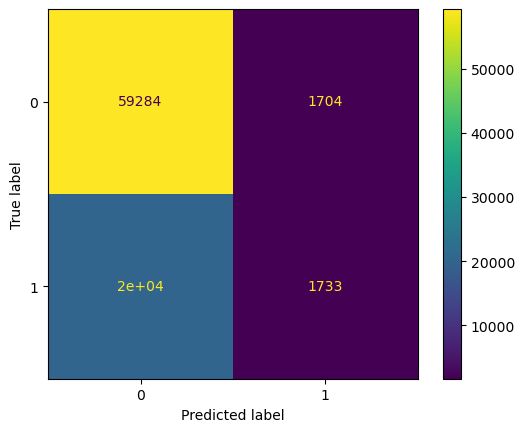

In [34]:
cm = confusion_matrix(y_true_df.to_numpy().flatten(), selected_eu_pred.to_numpy().flatten())
ConfusionMatrixDisplay(confusion_matrix=cm).plot()